# Testing LOSD
### Bevölkerung nach Stadtkreis, seit 1993

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Stadtkreis und Jahr, seit 1993.

https://data.integ.stadt-zuerich.ch/dataset/bev324od3242

Datum: 12.02.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3242_losd_bev_bestand_jahr_kreis_od3242.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [3]:
import sys
sys.path.append('../0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

In [8]:
package_name = "bev324od3242"

In [9]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "bev324od3242.csv"   
    , datums_attr = ['ZEIT_LANG']
    )

fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3242/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev324od3242 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3242 

data_source: web


In [10]:
data2betested.head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus
0,1762-12-31,Z31121762,Kreis 1 (Stadtgebiet vor 1893),R10000,11452,Definitiv
1,1948-12-31,Z31121948,Kreis 6 (ab 1934),R01200,48153,Definitiv


Berechne weitere Attribute falls notwendig

`ACHTUNG`!

In Pandas kann `datetime` Daten ab dem Jahr **1677** speichern. Das liegt daran, dass Pandas datetime64[ns] auf der Basis von NumPy verwendet, das wiederum den Datentyp datetime64 bereitstellt, der auf dem Standard des Proleptischen Gregorianischen Kalenders basiert. Dieser Kalender geht bis zum Jahr 1677 zurück.

Alternative: Abfangen des Problems mit Funktion:

-----------------------------------------------

In [11]:
def convert_to_datetime(date_str):
    try:
        date = pd.to_datetime(date_str)
        if date.year < 1677:
            raise ValueError("Datum liegt außerhalb des gültigen Bereichs für datetime-Objekte.")
        return date
    except ValueError:
        return pd.NaT  # Falls ein ungültiges Datum übergeben wurde, gib NaT (Not a Timestamp) zurück
        #return pd..to_datetime('2222-01-01') # Falls ein zu altes Datum drin ist, kann ich irgend ein Datum zuordnen


-------------------------------------------------------

In [12]:
data2betested = (
    data2betested
    .copy()
    .assign(
        StichtagDatJahr = lambda x: x.ZEIT_LANG.apply(convert_to_datetime),
        #StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        #Jahr = lambda x: x.ZEIT_lang.dt.year,
        Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_CODE.str[1:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
764,2023-12-31,Z31122023,Kreis 9 (ab 1934),R01400,59841,Provisorisch,2023-12-31,2023-12-31,2023,1400
632,2023-12-31,Z31122023,Kreis 8 (ab 1915),R01100,17860,Provisorisch,2023-12-31,2023-12-31,2023,1100
1131,2023-12-31,Z31122023,Kreis 11 (ab 1970),R01800,78801,Provisorisch,2023-12-31,2023-12-31,2023,1800
412,2023-12-31,Z31122023,Kreis 3 (ab 1915),R00600,50950,Provisorisch,2023-12-31,2023-12-31,2023,600
417,2023-12-31,Z31122023,Kreis 2 (ab 1893),R00200,37639,Provisorisch,2023-12-31,2023-12-31,2023,200
...,...,...,...,...,...,...,...,...,...,...
983,1671-12-31,Z31121671,Kreis 1 (Stadtgebiet vor 1893),R10000,9590,Definitiv,NaT,1671-12-31,1671,10000
952,1637-12-31,Z31121637,Kreis 1 (Stadtgebiet vor 1893),R10000,8621,Definitiv,NaT,1637-12-31,1637,10000
272,1529-12-31,Z31121529,Kreis 1 (Stadtgebiet vor 1893),R10000,5080,Definitiv,NaT,1529-12-31,1529,10000
88,1467-12-31,Z31121467,Kreis 1 (Stadtgebiet vor 1893),R10000,4750,Definitiv,NaT,1467-12-31,1467,10000


Minimales und maximales Jahr im Datensatz

In [13]:
data_max_date = str(max(data2betested.StichtagDatJahr).year)
data_min_date = str(min(data2betested.StichtagDatJahr).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")

Die Daten haben ein Minimumjahr von 1682 und ein Maximumjahr von 2023


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [14]:
docname = package_name +date_today+".csv"
print(docname)


bev324od3242_2024-06-24.csv


In [15]:
data2betested.to_csv('./saved_data/'+docname, index=False)

Zeitbereich aus den Daten:

In [16]:
data_max_date = str(max(data2betested.Jahr_nbr))

try:
    if min(data2betested.Jahr_nbr) < 1678:
        data_min_date="1688"
    else:
        data_min_date = str(min(data2betested.Jahr_nbr))
except ValueError:
    print("Fehler...")

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1688 und ein Maximumjahr von 2023


### Importiere SASA-Daten für einen Vergleich

In [17]:
sasa_data2betested = mypy_dl.load_data(
    status = 'prod'
    , data_source = 'web'
    , package_name = 'bev_bestand_jahr_kreis_od3242'
    , dataset_name = "bev324od3242"   
    , datums_attr = ['StichtagDatJahr']
    )

fp lautet:https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_kreis_od3242/download/BEV324OD3242.csv


 **Überprüfe die Metadaten:**

 **Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_kreis_od3242 

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev_bestand_jahr_kreis_od3242 

data_source: web


### Einfache Datentests

In [18]:
data2betested.head(2).T

,764,632
ZEIT_LANG,2023-12-31,2023-12-31
ZEIT_CODE,Z31122023,Z31122023
RAUM_LANG,Kreis 9 (ab 1934),Kreis 8 (ab 1915)
RAUM_CODE,R01400,R01100
BEW,59841,17860
Datenstatus,Provisorisch,Provisorisch
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31
Jahr_nbr,2023,2023
RAUM_my_sort,1400,1100


In [19]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1354 entries, 764 to 947
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_LANG            1354 non-null   object        
 1   ZEIT_CODE            1354 non-null   object        
 2   RAUM_LANG            1354 non-null   object        
 3   RAUM_CODE            1354 non-null   object        
 4   BEW                  1354 non-null   float64       
 5   Datenstatus          1354 non-null   object        
 6   StichtagDatJahr      1349 non-null   datetime64[ns]
 7   StichtagDatJahr_str  1354 non-null   object        
 8   Jahr_nbr             1354 non-null   int32         
 9   RAUM_my_sort         1354 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(6)
memory usage: 584.6 KB


In [20]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 1,354 rows (observations) and 10 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [21]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**


In [22]:
# Ersetze NaT-Werte durch ein spezifisches Datum (z.B. '2222-01-01')
data2betested = data2betested.fillna(pd.to_datetime('2222-01-01'))


In [23]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [24]:
print(data2betested.index)

DatetimeIndex(['1682-12-31', '1762-12-31', '1771-12-31', '1792-12-31', '1799-12-31', '1812-12-31',
               '1833-12-31', '1836-12-31', '1870-12-31', '1880-12-31',
               ...
               '2023-12-31', '2023-12-31', '2023-12-31', '2023-12-31', '2023-12-31', '2222-01-01',
               '2222-01-01', '2222-01-01', '2222-01-01', '2222-01-01'],
              dtype='datetime64[ns]', name='StichtagDatJahr', length=1354, freq=None)


In [25]:
data2betested.index.year.unique()


Index([1682, 1762, 1771, 1792, 1799, 1812, 1833, 1836, 1870, 1880,
       ...
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2222],
      dtype='int32', name='StichtagDatJahr', length=141)

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [26]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [27]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr_nbr,RAUM_my_sort
count,"1,354","1,354","1,354"
mean,"31,988","1,963","1,971"
std,"15,254",46,"2,819"
min,"3,237","1,408",200
25%,"20,918","1,939",700
50%,"30,847","1,967","1,200"
75%,"40,805","1,995","1,500"
max,"90,551","2,023","10,000"


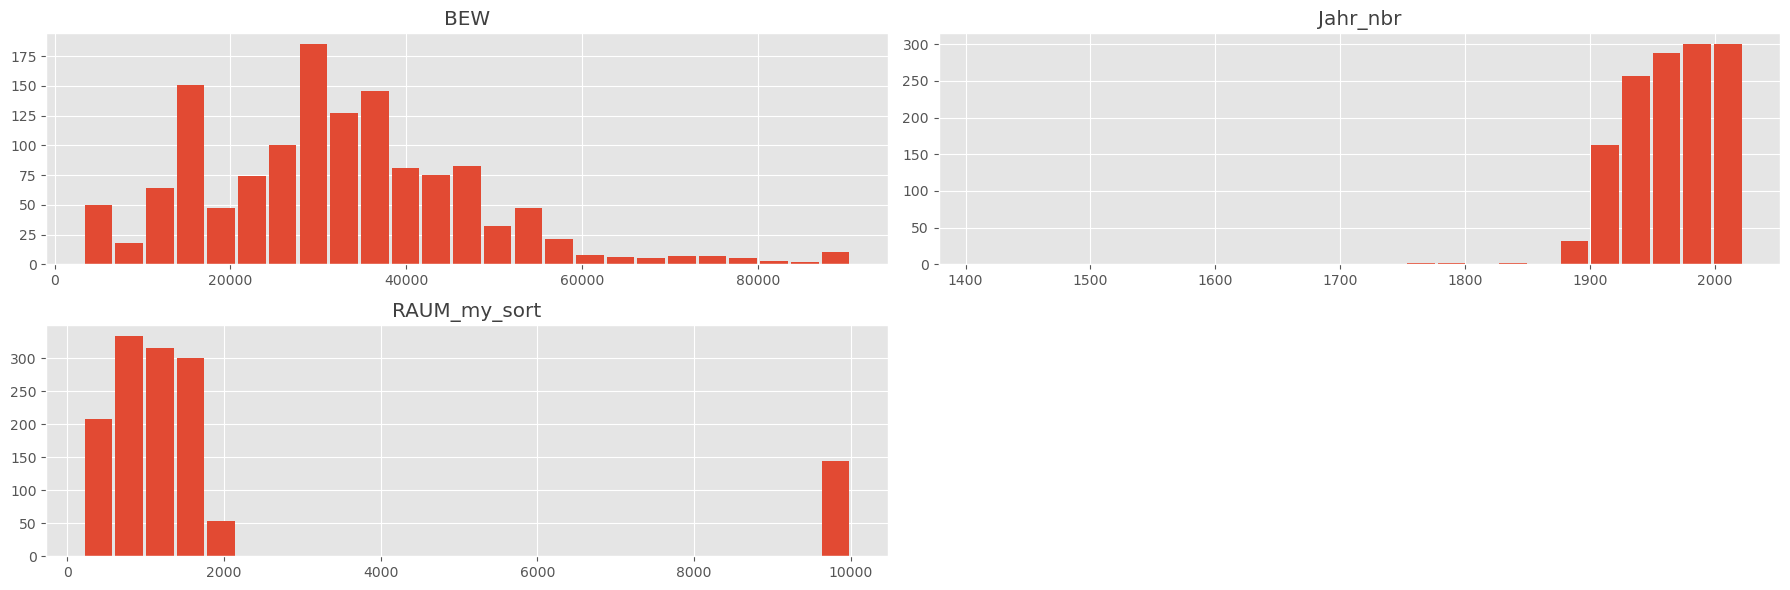

In [28]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [29]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,


### Nullwerte und Missings?

In [30]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
BEW                    0
Datenstatus            0
StichtagDatJahr_str    0
Jahr_nbr               0
RAUM_my_sort           0
dtype: int64

In [31]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [32]:
print(data_min_date)
print(data_max_date)

1688
2023


In [33]:
agg_jahr = data2betested\
    .groupby(['Jahr_nbr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr_nbr,sum_AnzBestWir
0,2023,447082
1,2022,443037
2,2021,436332


In [34]:
data2betested.RAUM_LANG.unique()

array(['Kreis 1 (Stadtgebiet vor 1893)', 'Kreis III (1893-1914)',
       'Kreis 8 (ab 1915)', 'Kreis 2 (ab 1893)',
       'alter Kreis V (1893-1914)',
       'alter Kreis 6 (1915-1933); alter Kreis IV (1893-1914)',
       'Kreis 3 (ab 1915)', 'alter Kreis 7 (1915-1933)',
       'Kreis 4 (ab 1915)', 'Kreis 5 (ab 1915)', 'Kreis 7 (ab 1934)',
       'Kreis 9 (ab 1934)', 'Kreis 6 (ab 1934)',
       'alter Kreis 11 (1934-1969)', 'Kreis 10 (ab 1934)',
       'altes Quartier Schwamendingen (1934-1969); Kreis 12 (ab 1970)',
       'Kreis 11 (ab 1970)'], dtype=object)

In [35]:
sasa_data2betested.columns

Index(['StichtagDatJahr', 'KreisSort', 'KreisCd', 'KreisLang', 'AnzBestWir'], dtype='object')

In [36]:
agg_Kreise_sasa = sasa_data2betested\
    .groupby(['StichtagDatJahr', 'KreisSort', 'KreisCd', 'KreisLang']) \
    .agg(sum_AnzBestWir=('AnzBestWir', 'sum')) \
    .sort_values(['KreisSort', 'StichtagDatJahr',], ascending=[False, True]) 
#agg_Kreise_sasa.reset_index().tail(50)

In [37]:
#.query("RAUM_CODE =='R10000'")
agg_Kreise = data2betested\
    .groupby(['Jahr_nbr','RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values(['Jahr_nbr','RAUM_CODE'], ascending=[False, False]) 
agg_Kreise.reset_index().tail(5)

,Jahr_nbr,RAUM_LANG,RAUM_CODE,sum_AnzBestWir
1349,1671,Kreis 1 (Stadtgebiet vor 1893),R10000,9590
1350,1637,Kreis 1 (Stadtgebiet vor 1893),R10000,8621
1351,1529,Kreis 1 (Stadtgebiet vor 1893),R10000,5080
1352,1467,Kreis 1 (Stadtgebiet vor 1893),R10000,4750
1353,1408,Kreis 1 (Stadtgebiet vor 1893),R10000,5675


### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [38]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Kreis 9 (ab 1934),R01400,59841,Provisorisch,2023-12-31,2023,1400
2023-12-31,2023-12-31,Z31122023,Kreis 1 (Stadtgebiet vor 1893),R10000,5890,Provisorisch,2023-12-31,2023,10000


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [39]:
data2betested.reset_index().dtypes

StichtagDatJahr        datetime64[ns]
ZEIT_LANG                      object
ZEIT_CODE                      object
RAUM_LANG                      object
RAUM_CODE                      object
BEW                           float64
Datenstatus                    object
StichtagDatJahr_str            object
Jahr_nbr                        int32
RAUM_my_sort                    int32
dtype: object

In [40]:
#myAggAll = data2betested.loc[data_min_date:data_max_date]
data2betested[['myAggr']] = "ZH"

myAgg1 = data2betested.loc["1890":data_max_date]\
    .groupby(['StichtagDatJahr','myAggr','Datenstatus']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg1.reset_index().head(2)

,StichtagDatJahr,myAggr,Datenstatus,sum_WBev
0,2023-12-31,ZH,Provisorisch,447082
1,2022-12-31,ZH,Veröffentlicht,443037


In [41]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,y = 'sum_WBev:Q'
    ,x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Personen'
    ,category = "Datenstatus:N"
    ,category_beschriftung= 'Legende:'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Bevölkerungsentwicklung, seit "+data_min_date
)
grafik1

alt.LayerChart(...)

In [42]:
grafic_name = package_name+"_alt1_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik1.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3242_alt1_total_2024-06-24.png


#### Entwicklung Wohnbevölkerung nach Stadtkreis seit ...

In [43]:
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg2.reset_index().head(3)

,StichtagDatJahr,RAUM_LANG,RAUM_CODE,sum_WBev
0,2023-12-31,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,33537
1,2023-12-31,Kreis 4 (ab 1915),R00700,29944
2,2023-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,5890


In [44]:
grafik2 =mypy_dv.plot_altair_multiline_highlight(
    data = myAgg2.reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = 'RAUM_LANG:N'
    ,category_beschriftung= 'Stadtkreise:'
    , myTitle="Bevölkerung nach Stadtkreis, seit "+data_min_date
    #, myTitle="Bevölkerung nach Stadtkreis, 1920-1980"
)
grafik2

alt.LayerChart(...)

In [45]:
grafic_name = package_name+"_alt2_raum_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik2.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3242_alt2_raum_zeit_2024-06-24.png


In [46]:
myAgg3 = data2betested.loc["1920":"1980"]\
    .groupby(['StichtagDatJahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg3.reset_index().head(3)

,StichtagDatJahr,RAUM_LANG,RAUM_CODE,sum_WBev
0,1980-12-31,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,29456
1,1980-12-31,Kreis 4 (ab 1915),R00700,28701
2,1980-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,7008


In [47]:
grafik3 =mypy_dv.plot_altair_multiline_highlight(
    data = myAgg3.reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = 'RAUM_LANG:N'
    ,category_beschriftung= 'Stadtkreise:'
    , myTitle="Bevölkerung nach Stadtkreis, 1920-1980"
)
grafik3

alt.LayerChart(...)

In [48]:
grafic_name = package_name+"_alt3_raum_zeit_sel"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik3.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3242_alt3_raum_zeit_sel_2024-06-24.png


#### Barcharts mit Seaborn

In [49]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["1960":"1972"]\
    .groupby(['StichtagDatJahr','Jahr_nbr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr_nbr,RAUM_LANG,RAUM_CODE,sum_WBev
0,1960-12-31,1960,Kreis 1 (Stadtgebiet vor 1893),R10000,14674
1,1960-12-31,1960,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,33360
2,1960-12-31,1960,alter Kreis 11 (1934-1969),R01600,86657


In [50]:
#help(sns.catplot)     

In [51]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

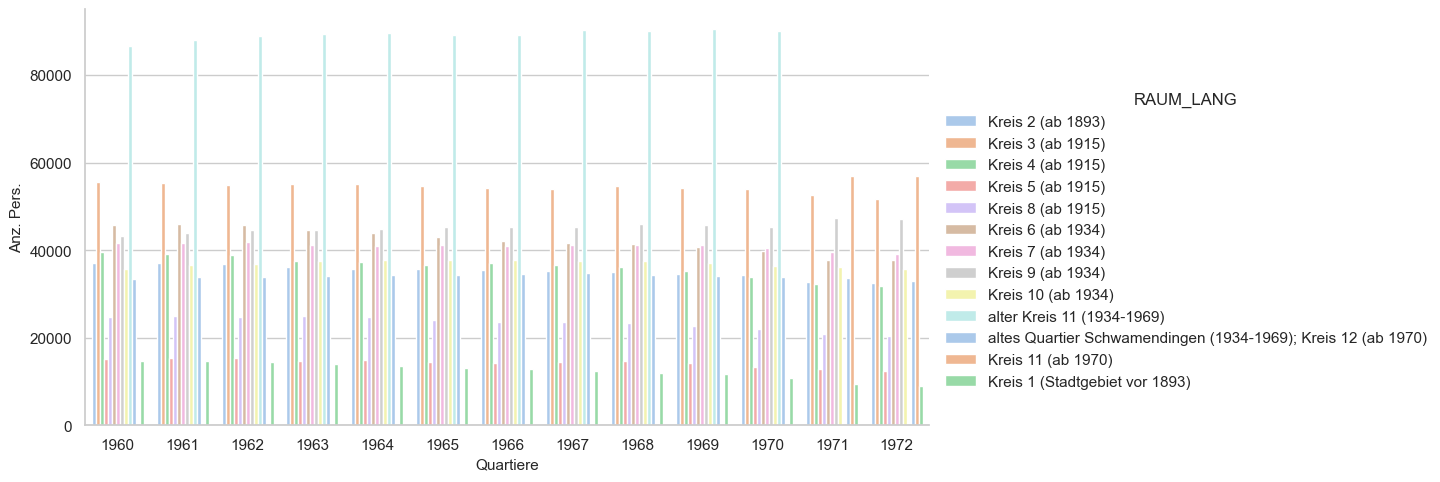

In [52]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_nbr"
            , y="sum_WBev"
            , hue="RAUM_LANG"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_CODE", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


#### Faced Grids

In [53]:
myFG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myFG

,,,,,sum_WBev
Jahr_nbr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,
1957,1957-12-31,Kreis 2 (ab 1893),R00200,200,36804
2005,2005-12-31,Kreis 2 (ab 1893),R00200,200,28834
1933,1933-12-31,Kreis 2 (ab 1893),R00200,200,26497
1934,1934-12-31,Kreis 2 (ab 1893),R00200,200,27313
1994,1994-12-31,Kreis 2 (ab 1893),R00200,200,28622
...,...,...,...,...,...
1963,1963-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,13938
2014,2014-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,5616
1962,1962-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,14536


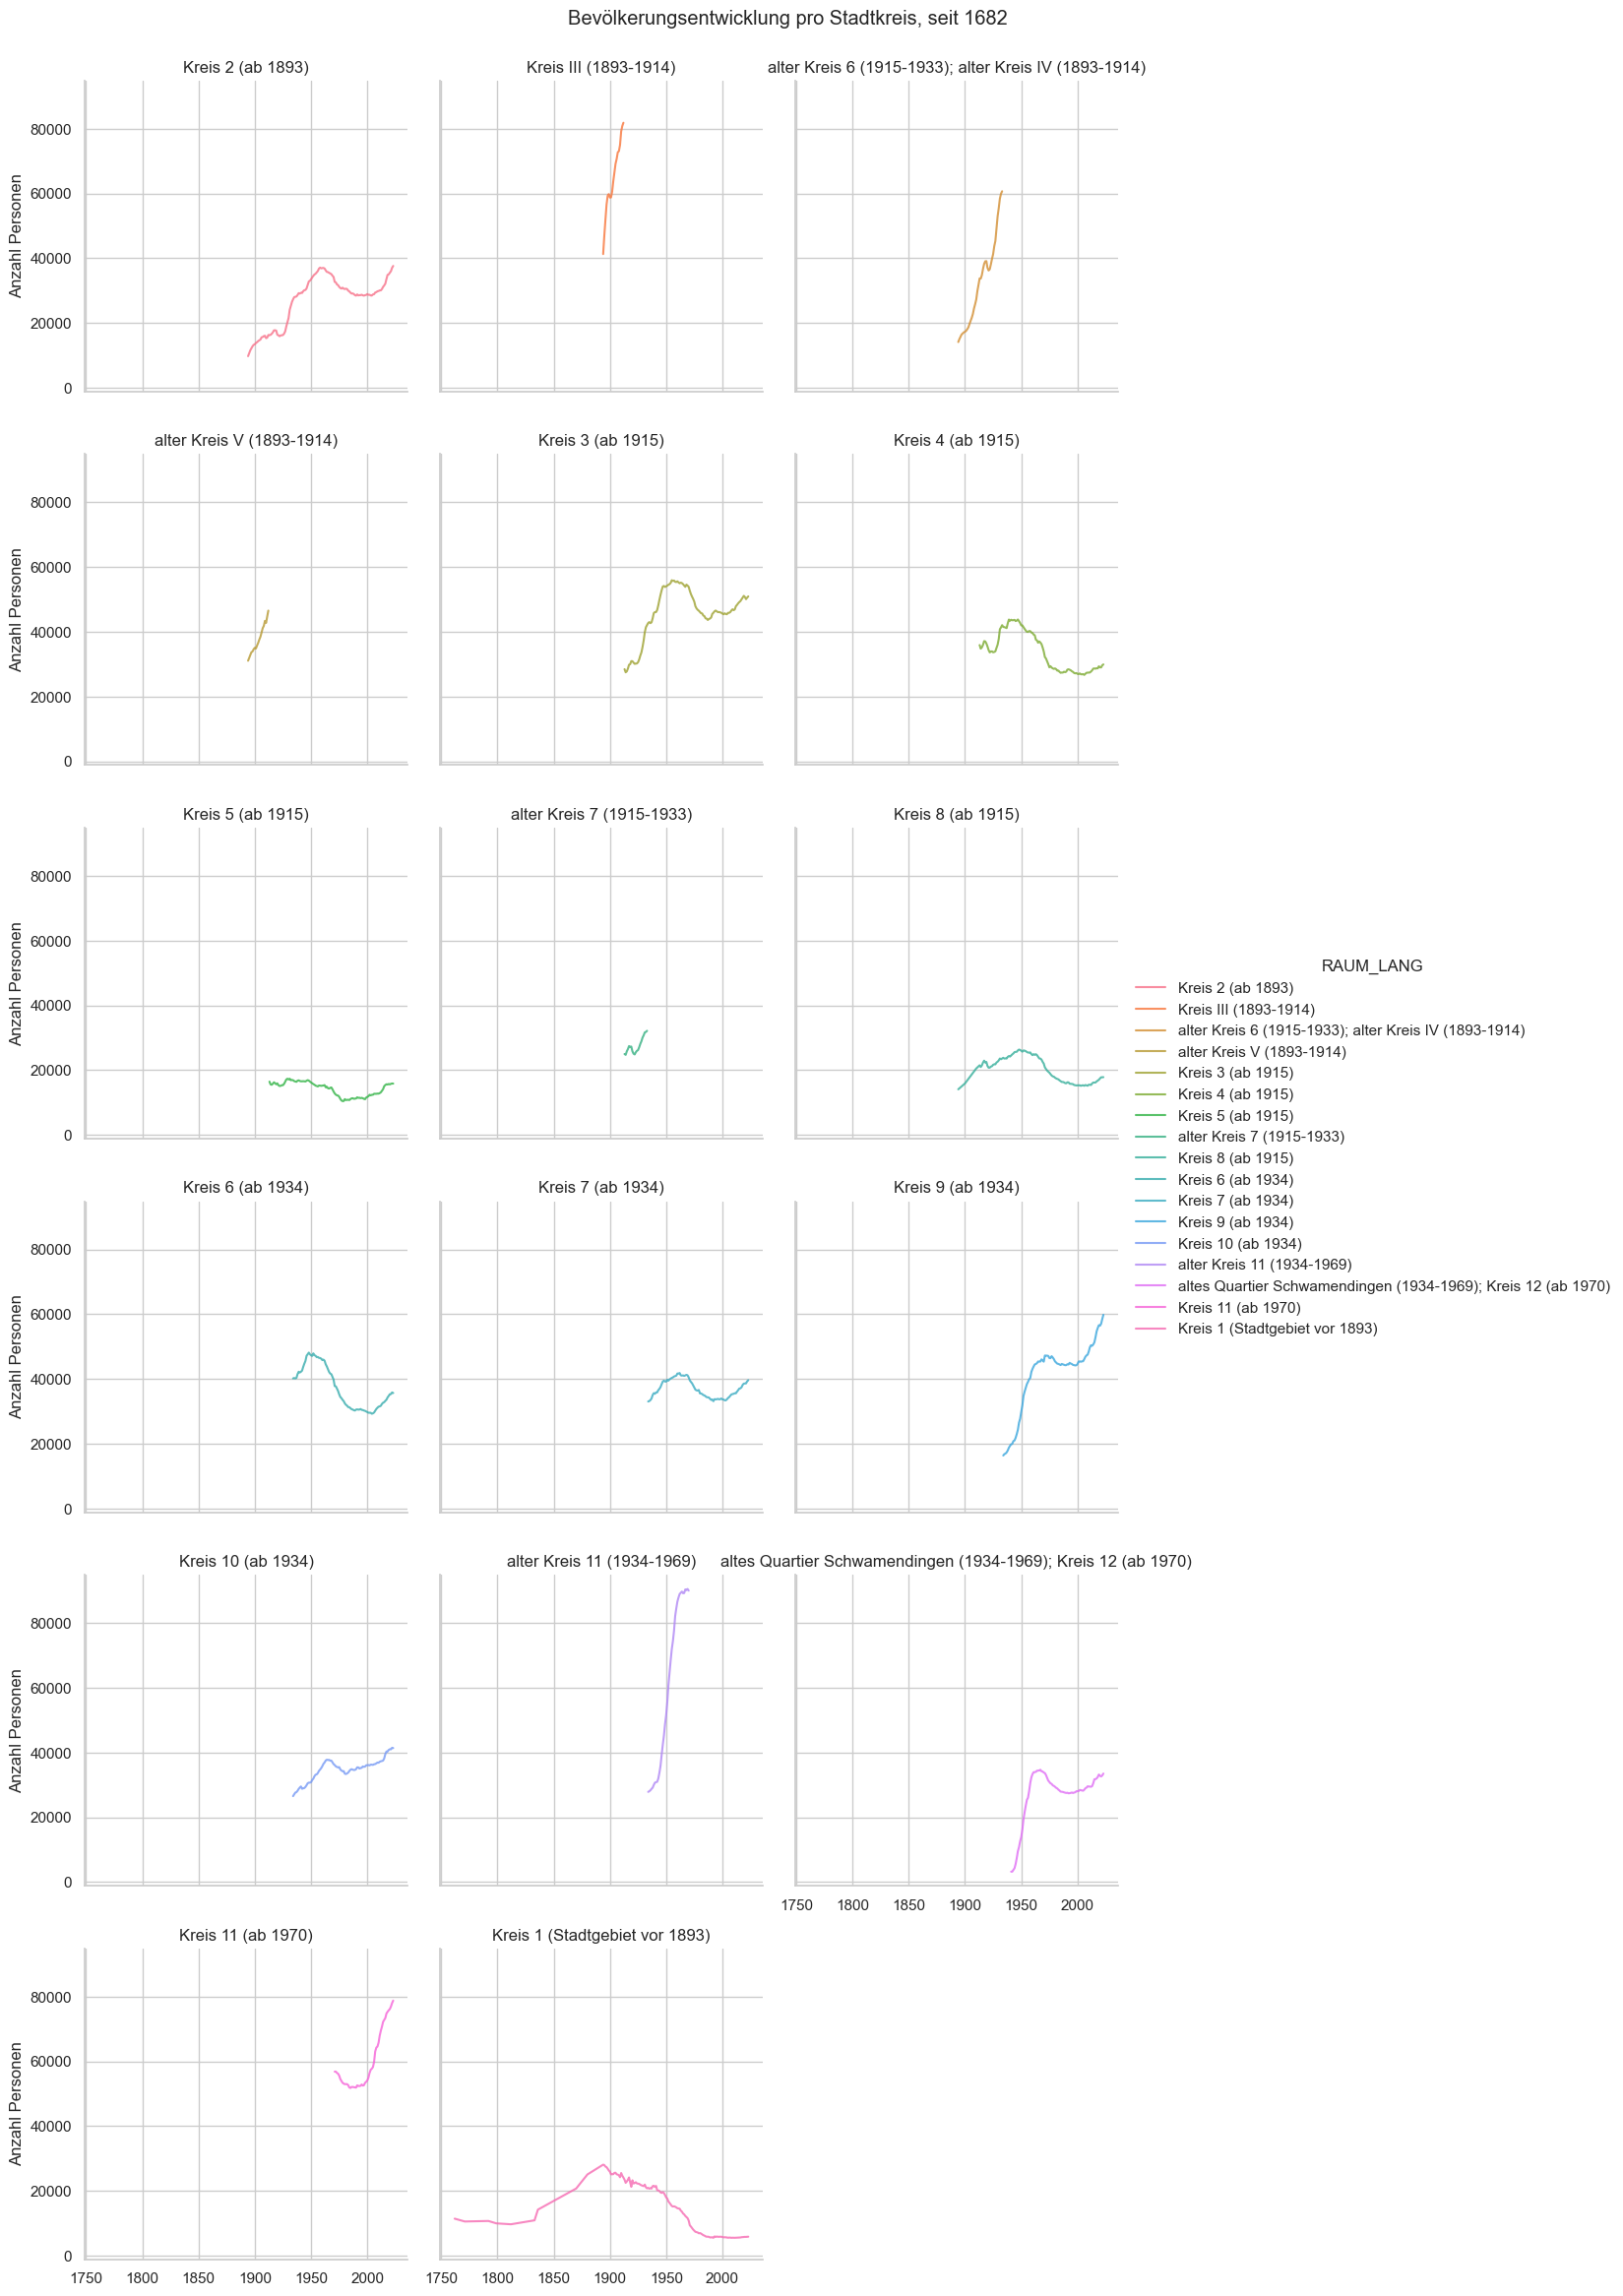

In [54]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG.reset_index().sort_values('RAUM_CODE', ascending=True)
    ,col = "RAUM_LANG"
    ,hue = "RAUM_LANG"
    ,col_wrap = 3
    ,grafiktyp = sns.lineplot
    ,x = "Jahr_nbr"
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,height = 4
    ,myTitle="Bevölkerungsentwicklung pro Stadtkreis, seit "+str(int(data2betested.index.year.min()))
)
faced_grid1

In [55]:
grafic_name = package_name+"_fg_histKreis_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid1.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3242_fg_histKreis_zeit__2024-06-24.png


In [56]:
myFG2 = data2betested.loc["1915":"1980"]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=True) 

myFG2

sum_WBev
Jahr_nbr StichtagDatJahr_str RAUM_LANG                                          RAUM_CODE RAUM_my_sort          
1915     1915-12-31          Kreis 1 (Stadtgebiet vor 1893)                     R10000    10000            22932
                             Kreis 2 (ab 1893)                                  R00200    200              16679
                             Kreis 3 (ab 1915)                                  R00600    600              27794
                             Kreis 4 (ab 1915)                                  R00700    700              35203
                             Kreis 5 (ab 1915)                                  R00800    800              15499
...                                                                                                          ...
1980     1980-12-31          Kreis 10 (ab 1934)                                 R01500    1500             33501
                             Kreis 1 (Stadtgebiet vor 1893)                     R10000    10000             7008
                             Kreis 9 (ab 1934)                                  R01400    1400             45454
                             Kreis 3 (ab 1915)                                  R00600    600              46150
                             altes Quartier Schwamendingen (1934-1969); Krei... R01700    1700             29456

[709 rows x 1 columns]

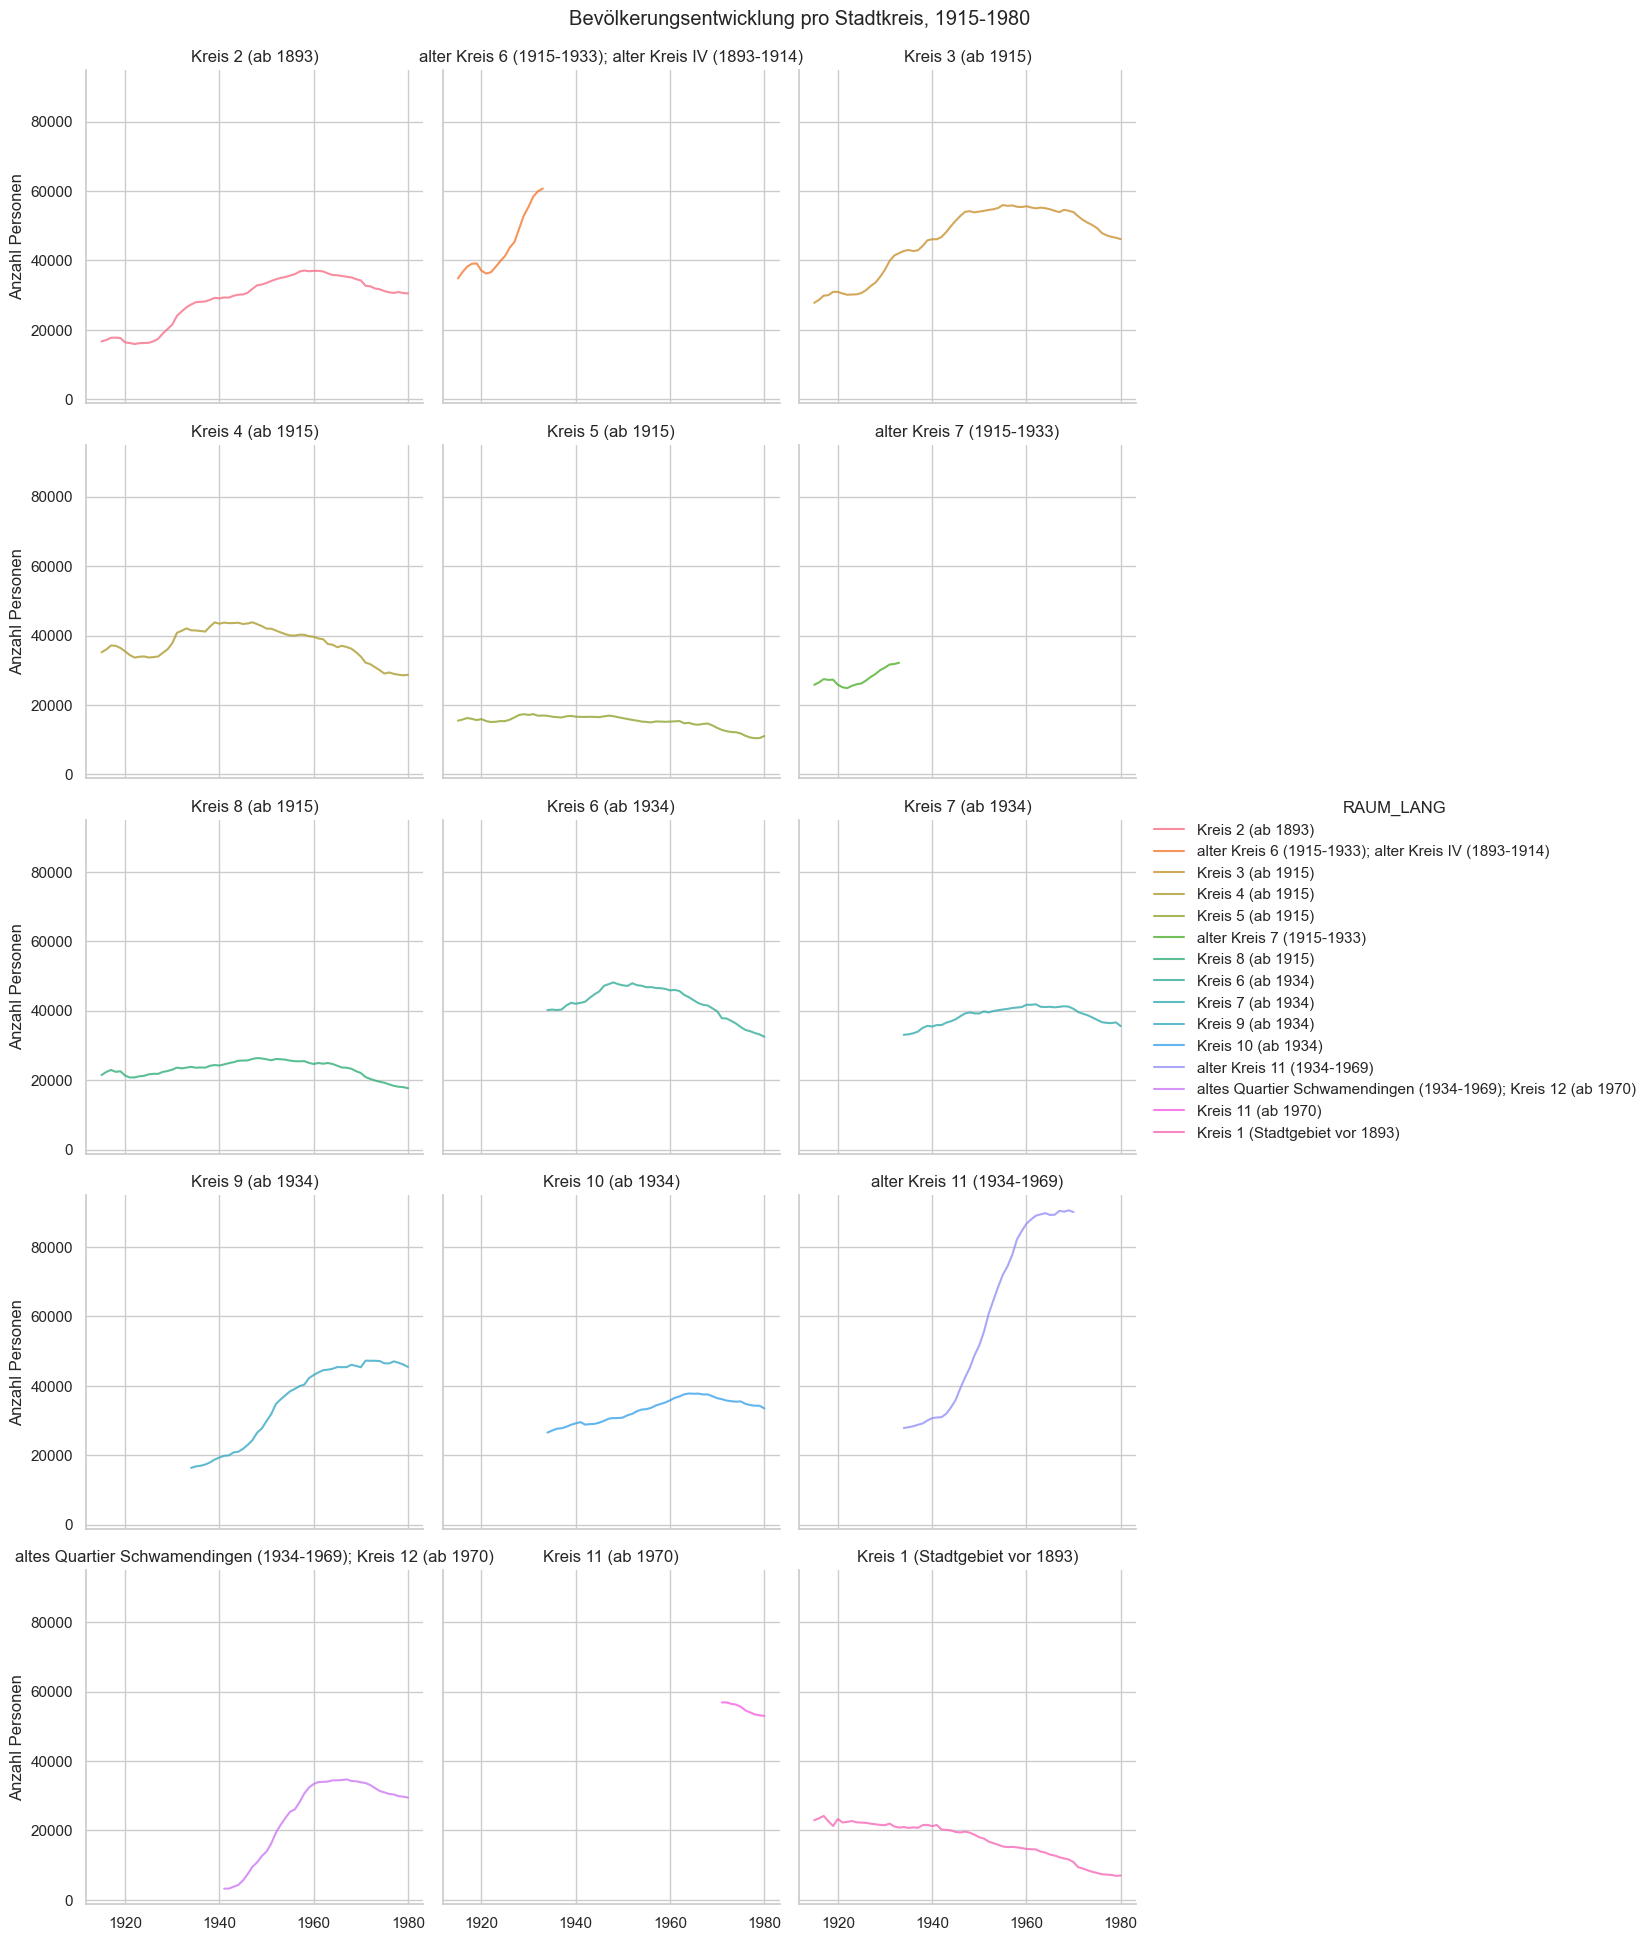

In [57]:
faced_grid2 = mypy_dv.plot_sns_facetgrid(
    data = myFG2.reset_index().sort_values('RAUM_CODE', ascending=True)
    ,col = "RAUM_LANG"
    ,hue = "RAUM_LANG"
    ,col_wrap = 3
    ,grafiktyp = sns.lineplot
    ,x = "Jahr_nbr"
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,height = 4
    ,myTitle="Bevölkerungsentwicklung pro Stadtkreis, 1915-1980"
)
faced_grid2

In [58]:
grafic_name = package_name+"_fg_histKreis_zeit_sel"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid2.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3242_fg_histKreis_zeit_sel_2024-06-24.png


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)